# TOB Exchange Example

In this example we implement a very simple top-of-book imbalance. We measure imbalance as the bid pressure
$$i_t = \frac{bq_t}{bq_t + aq_t}$$
Where $bq$ is the bid quantity and $aq$ the ask quantity on the top of the orderbook.

In [1]:
import os 
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange

%load_ext autoreload 
%autoreload 2

In [2]:
base = 'BTC'
quote = 'USDT'
symbol = base + quote

## Import Data

In [3]:
folder_path = 'data_loader/datasets/'

In [4]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)

    df['time'] = pd.to_datetime(df.timestamp, unit='us')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    return df

In [5]:
# define folder path
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    # and f.split('_')[-1] == f'{quote}-{base}.csv.gz'
    and f.split('_')[-1] == f'{base+quote}.csv.gz'
    and f.split('_')[1] == 'quotes']


tfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == base+quote+'.csv.gz'
    and f.split('_')[1] == 'trades']

print(files_list, tfiles_list)

['binance_quotes_2023-07-01_BTCUSDT.csv.gz'] ['binance_trades_2023-07-01_BTCUSDT.csv.gz']


In [6]:
binance_data = get_data(files_list)
binance_trades_data = get_data(tfiles_list)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


## Open Exchange

In [7]:
# Create new exchange called binance with a average latency of 5000 us and 29% std
binance = TOB_Exchange(latency=[5000, 0.29])
# Were traing one market in this example, so were adding it to the markets
binance.add_market(symbol, base, quote)
# We start with a balance for only BTC 
binance.add_balance(base, 0)
binance.add_balance(quote, 10_000)

# Now we can load the TOB data into the exchange events
lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
binance_trades_lst = binance_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()
binance.load_tob(lst, symbol)
binance.load_trades(binance_trades_lst, symbol)

2023-07-23 19:27:17,572 - INFO - src.exchange - Loading 487428 TOB-Updates for BTCUSDT
2023-07-23 19:27:19,229 - INFO - src.exchange - TOB-Updates loaded successfully
2023-07-23 19:27:19,230 - INFO - src.exchange - Loading 567976 trades for BTCUSDT
2023-07-23 19:27:20,971 - INFO - src.exchange - Trades loaded successfully


## Strategy

In [8]:
binance_data['imb'] = binance_data.bid_amount / (binance_data.bid_amount + binance_data.ask_amount)

In [15]:
# Our signal is a simple top-of-book pressure. 
# If the TOB is dominated by buys (99.9% of the TOB quanitites are buys) then we enter a market buy order
# If the TOB is dominated by sells (0.1% of the TOB quanitites are buys) then we enter a market sell order

def signal(tob):
    bid_pressure = tob['bid_quantity'] / (tob['bid_quantity'] + tob['ask_quantity'])

    if bid_pressure >= 0.999: 
        return 1 
    
    elif bid_pressure <= 0.001: 
        return -1 
    
    else: 
        return 0

# We can now embed this signal into a simple strategy class that runs on every update

class tob_imbalance(): 
    def __init__(self, symbol):
        self.symbol = symbol
        self.amount = 0.1

        self.flag = False
        
    def run_strategy(self):

        tob = binance.fetch_tob(self.symbol)

        decision = signal(tob)

        if (decision == 1) and not (self.flag): 
            binance.market_order(symbol, self.amount, 1, tob['timestamp'])
            self.flag = True

        elif (decision == -1) and (self.flag): 
            binance.market_order(symbol, self.amount, 0, tob['timestamp'])
            self.flag = False

        else: 
            pass

In [16]:
binance.run_simulation(tob_imbalance, symbol)

2023-07-23 19:28:08,544 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=567976, order_id=0, side=1, taker=True, amount=0.1, price=30470.86, fees=0.6094172000000001, entryTime=1688169739719173.0, eventTime=1688169739721939.5)
2023-07-23 19:28:08,555 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=567977, order_id=1, side=0, taker=True, amount=0.1, price=30486.85, fees=0.609737, entryTime=1688169824559849.0, eventTime=1688169824563873.0)
2023-07-23 19:28:08,574 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=567978, order_id=2, side=1, taker=True, amount=0.1, price=30500.58, fees=0.6100116000000001, entryTime=1688170042971764.2, eventTime=1688170042977835.0)
2023-07-23 19:28:08,590 - INFO - src.exchange - Trade Executed Trade(symbol='BTCUSDT', trade_id=567979, order_id=3, side=0, taker=True, amount=0.1, price=30503.38, fees=0.6100676, entryTime=1688170221755697.5, eventTime=1688170221761801.2)
2023-07-23 19:28:08,611

In [17]:
balances = pd.DataFrame(binance.historical_balance)
balances['comp_usd'] = balances[base] * balances.mid
balances['combined'] = balances.comp_usd + balances[quote]

## PnL Analytics

In [18]:
df_o = pd.DataFrame(binance.orders)

In [19]:
df_t = pd.DataFrame(binance.trades)

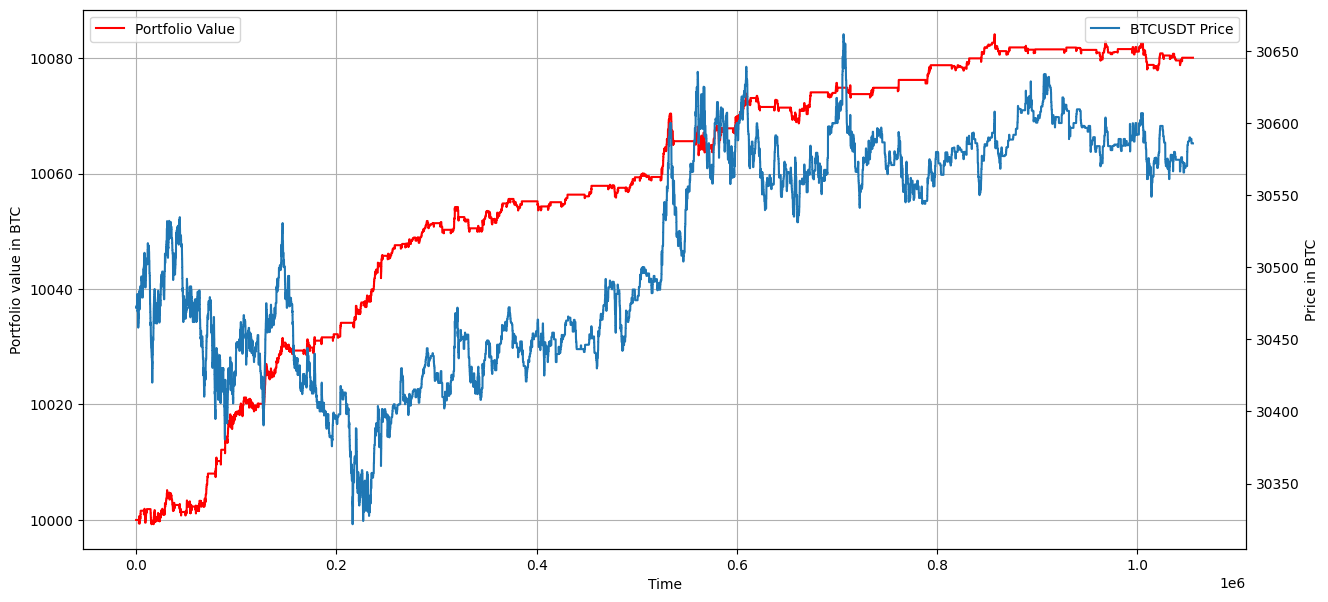

In [20]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(balances.combined, label='Portfolio Value', color='r')

ax2 = ax.twinx()
ax2.plot(balances.mid, label=symbol+' Price')
ax.set_xlabel('Time')
ax2.set_ylabel('Price in BTC')
ax.set_ylabel('Portfolio value in BTC')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.grid()